In [42]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import sklearn as skl
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


In [43]:
ts = TimeSeries(key='AJH8MF4OQ465LD6H',output_format='pandas')
data, meta_data = ts.get_daily(symbol='INX', outputsize='full')


In [45]:
data = data.sort_values(by = 'date')
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2000-01-03,1469.2500,1478.0000,1438.3600,1455.2200,9.318000e+08
2000-01-04,1455.2200,1455.2200,1397.4301,1399.4200,1.009000e+09
2000-01-05,1399.4200,1413.2700,1377.6801,1402.1100,1.085500e+09
2000-01-06,1402.1100,1411.9000,1392.1000,1403.4500,1.092300e+09
2000-01-07,1403.4500,1441.4700,1400.7300,1441.4700,1.225200e+09
...,...,...,...,...,...
2020-03-09,2863.8899,2863.8899,2734.4299,2746.5601,8.423050e+09
2020-03-10,2813.4800,2882.5901,2734.0000,2882.2300,7.635960e+09
2020-03-11,2825.6001,2825.6001,2707.2200,2741.3799,7.374110e+09


In [46]:
#Create a new dataframe for open price
data = data.filter(['1. open'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = int( len(dataset) * .8 )

training_data_len

4064

In [47]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.29245475],
       [0.28726071],
       [0.26660299],
       ...,
       [0.79458905],
       [0.72249436],
       [0.69995965]])

In [48]:
#Create and scale the training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
X_train = []
y_train = []

for i in range(100, len(train_data)):
  X_train.append(train_data[i-100:i, 0])
  y_train.append(train_data[i, 0])

In [49]:
train_data

array([[0.29245475],
       [0.28726071],
       [0.26660299],
       ...,
       [0.46372128],
       [0.47226572],
       [0.46937068]])

In [50]:
#Convert the train data to numpy arrays 
X_train, y_train = np.array(X_train), np.array(y_train)

In [51]:
#Reshape to 3D from 2D to fit into LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3964, 100, 1)

In [9]:
#Define Model
model = Sequential()

#input later
model.add(LSTM(100, return_sequences=True, input_shape= (X_train.shape[1], 1)))

#second layer
model.add(LSTM(50, return_sequences= False))

#third
model.add(Dense(25))

#Output
model.add(Dense(1))


#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:

#Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
3964/3964 [==============================] - 1350s 341ms/step - loss: 4.9634e-04


In [58]:
#Test the model
test_data = scaled_data[training_data_len - 100: , :]
#Create the data sets x_test and y_test
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(100, len(test_data)):
  X_test.append(test_data[i-100:i, 0])

In [59]:
#Convert the data to a numpy array
X_test = np.array(X_test)

In [60]:
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [61]:
#Get the models predicted price values 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


/Users/jaychung/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


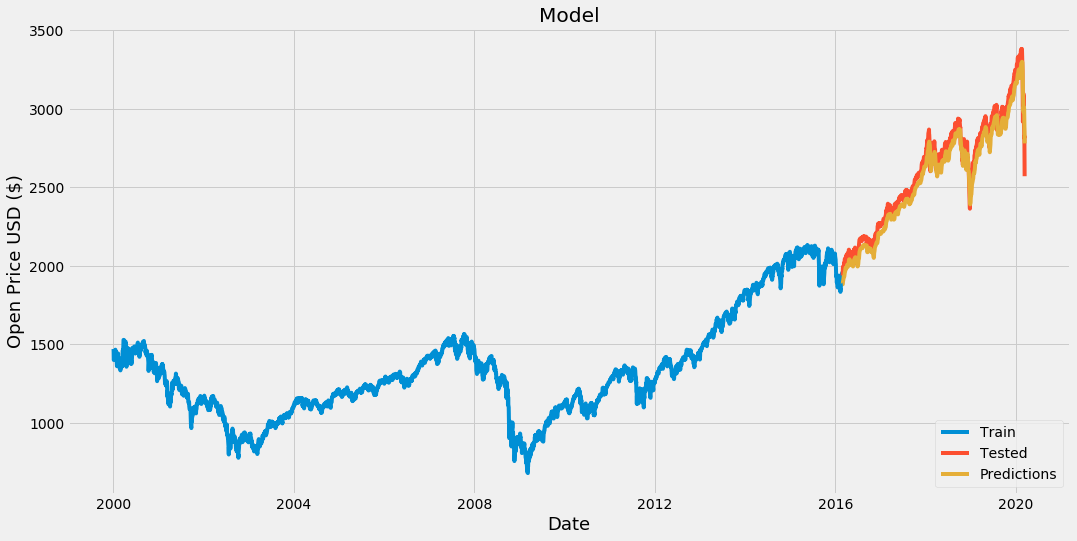

In [63]:
#Plot the data
train = data[:training_data_len]
tested = data[training_data_len:]
tested['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['1. open'])
plt.plot(tested[['1. open', 'Predictions']])
plt.legend(['Train', 'Tested', 'Predictions'], loc='lower right')
plt.show()

In [64]:
tested

,1. open,Predictions
date,,
2016-03-01,1937.0900,1881.592529
2016-03-02,1976.6000,1881.731567
2016-03-03,1985.6000,1889.384399
2016-03-04,1994.0100,1900.355103
2016-03-07,1996.1100,1912.141357
...,...,...
2020-03-09,2863.8899,2999.099854
2020-03-10,2813.4800,2956.851807
2020-03-11,2825.6001,2900.676025
